# LAB 3: How to setup a project from Scratch

In [1]:
!rm -rf speech-emotion-recognition-25

# Step 1: Clone your project from Github

In [2]:
#main
#!git clone https://github.com/MatteoPaglia/speech-emotion-recognition-25.git

#             nome branch

!git clone -b IemocapClass https://github.com/MatteoPaglia/speech-emotion-recognition-25.git

Cloning into 'speech-emotion-recognition-25'...
remote: Enumerating objects: 328, done.
remote: Counting objects: 100% (234/234), done.
remote: Compressing objects: 100% (154/154), done.
remote: Total 328 (delta 165), reused 142 (delta 76), pack-reused 94 (from 3)
Receiving objects: 100% (328/328), 126.41 KiB | 2.53 MiB/s, done.
Resolving deltas: 100% (201/201), done.


In [3]:
!ls

sample_data  speech-emotion-recognition-25


In [4]:
# %cd mldl_project_skeleton
%cd speech-emotion-recognition-25

/content/speech-emotion-recognition-25


In [5]:
!ls

checkpoints  dataset  models	 requirements.txt		  train.py
data	     eval.py  README.md  SpeechEmotionRecnognition.ipynb  utils


# Step 2: Packages Installation


In [6]:
%pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.0 MB/s eta 0:00:0000:0100:01


# Step 3: Dataset Setup
## Different options
- First one is downloading using a script that places the data in the download folder (usually recommended)
- Second one is uploading the dataset to your personal/institutional Google Drive and load it from there ([Read More](https://saturncloud.io/blog/google-colab-how-to-read-data-from-my-google-drive/))
- Place the download script directly here on colab

You are free to do as you please in this phase.


In [7]:
!python utils/download_dataset.py

--- 1. Configurazione Kaggle ---
Kaggle configurato con successo.

--- Download RAVDESS ---
Contatto KaggleHub per scaricare: uwrfkaggler/ravdess-emotional-speech-audio...
Using Colab cache for faster access to the 'ravdess-emotional-speech-audio' dataset.
✓ Dataset scaricato nella cache di sistema: /kaggle/input/ravdess-emotional-speech-audio
RAVDESS pronto in cache: /kaggle/input/ravdess-emotional-speech-audio
Numero totale di file: 2880

--- Download IEMOCAP ---
Contatto KaggleHub per scaricare: dejolilandry/iemocapfullrelease...
Using Colab cache for faster access to the 'iemocapfullrelease' dataset.
✓ Dataset scaricato nella cache di sistema: /kaggle/input/iemocapfullrelease
IEMOCAP pronto in cache: /kaggle/input/iemocapfullrelease
Numero totale di file: 81249

RIEPILOGO DOWNLOAD
RAVDESS: ✅ Successo
IEMOCAP: ✅ Successo

🎉 Tutti i dataset sono stati scaricati con successo!


In [8]:
from torch.utils.data import DataLoader
from dataset.custom_iemocap_dataset import CustomIEMOCAPDataset
from dataset.custom_ravdess_dataset import CustomRAVDESSDataset

print(f"////////////////////////////////////////////////////////////////////////////////////////////")
print(f"Dataset IEMOCAP")
print(f"////////////////////////////////////////////////////////////////////////////////////////////")

# Dataset IEMOCAP path
dataset_IEMOCAP_path ='/kaggle/input/iemocapfullrelease/IEMOCAP_full_release' #'/root/.cache/kagglehub/datasets/dejolilandry/iemocapfullrelease/versions/1/IEMOCAP_full_release'

# Create IEMOCAPdatasets
train_IEMOCAP_dataset = CustomIEMOCAPDataset(dataset_root=dataset_IEMOCAP_path, split='train')
val_IEMOCAP_dataset = CustomIEMOCAPDataset(dataset_root=dataset_IEMOCAP_path, split='validation')
test_IEMOCAP_dataset = CustomIEMOCAPDataset(dataset_root=dataset_IEMOCAP_path, split='test')

print(f"Train samples: {len(train_IEMOCAP_dataset)}")
print(f"Val samples: {len(val_IEMOCAP_dataset)}")
print(f"Test samples: {len(test_IEMOCAP_dataset)}")

# Create IEMOCAP DataLoaders
batch_size = 4
train_IEMOCAP_dataloader = DataLoader(train_IEMOCAP_dataset, batch_size=batch_size, shuffle=True)
val_IEMOCAP_dataloader = DataLoader(val_IEMOCAP_dataset, batch_size=batch_size, shuffle=False)
test_IEMOCAP_dataloader = DataLoader(test_IEMOCAP_dataset, batch_size=batch_size, shuffle=False)


print(f"////////////////////////////////////////////////////////////////////////////////////////////")
print(f"Dataset RAVDESS")
print(f"////////////////////////////////////////////////////////////////////////////////////////////")

# Dataset RAVDESS path
dataset_RAVDESS_path = '/kaggle/input/ravdess-emotional-speech-audio'

# Create RAVDESS datasets
train_RAVDESS_dataset = CustomRAVDESSDataset(dataset_root=dataset_RAVDESS_path, split='train')
val_RAVDESS_dataset = CustomRAVDESSDataset(dataset_root=dataset_RAVDESS_path, split='validation')
test_RAVDESS_dataset = CustomRAVDESSDataset(dataset_root=dataset_RAVDESS_path, split='test')

print(f"Train samples: {len(train_RAVDESS_dataset)}")
print(f"Val samples: {len(val_RAVDESS_dataset)}")
print(f"Test samples: {len(test_RAVDESS_dataset)}")

# Create RAVDESS DataLoaders
batch_size = 4
train_RAVDESS_dataloader = DataLoader(train_RAVDESS_dataset, batch_size=batch_size, shuffle=True)
val_RAVDESS_dataloader = DataLoader(val_RAVDESS_dataset, batch_size=batch_size, shuffle=False)
test_RAVDESS_dataloader = DataLoader(test_RAVDESS_dataset, batch_size=batch_size, shuffle=False)

////////////////////////////////////////////////////////////////////////////////////////////
Dataset IEMOCAP
////////////////////////////////////////////////////////////////////////////////////////////
Starting to collect samples from: /kaggle/input/iemocapfullrelease/IEMOCAP_full_release
✅ Collected 80 samples in total
   - Improvised samples only
   - Emotions: ['neutral', 'happy', 'sad', 'angry']
📊 Statistiche del dataset IEMOCAP:
   Train:      Sessions ['1', '2', '3'] (2 speakers) → 48 campioni (60.0%) | Lunghezza media: 3.85s

👤 Speaker distribution:
   Train:      M=1, F=1
✅ Dataset initialized: 48 train samples
Starting to collect samples from: /kaggle/input/iemocapfullrelease/IEMOCAP_full_release
✅ Collected 80 samples in total
   - Improvised samples only
   - Emotions: ['neutral', 'happy', 'sad', 'angry']
📊 Statistiche del dataset IEMOCAP:
   Validation: Sessions ['4'] (2 speakers) → 16 campioni (20.0%) | Lunghezza media: 4.11s

👤 Speaker distribution:
   Validation: M=1, F=

Loading IEMOCAP samples...

📊 Calcolando media durata POST-TRIMMING per split 'train'...
   9/48 file processati...
   18/48 file processati...
   27/48 file processati...
   36/48 file processati...
   45/48 file processati...
✅ Media calcolata: 3.79s (60654 campioni)



ValueError: Invalid emotion label: None. Only ['neu', 'hap', 'sad', 'ang'] are supported.

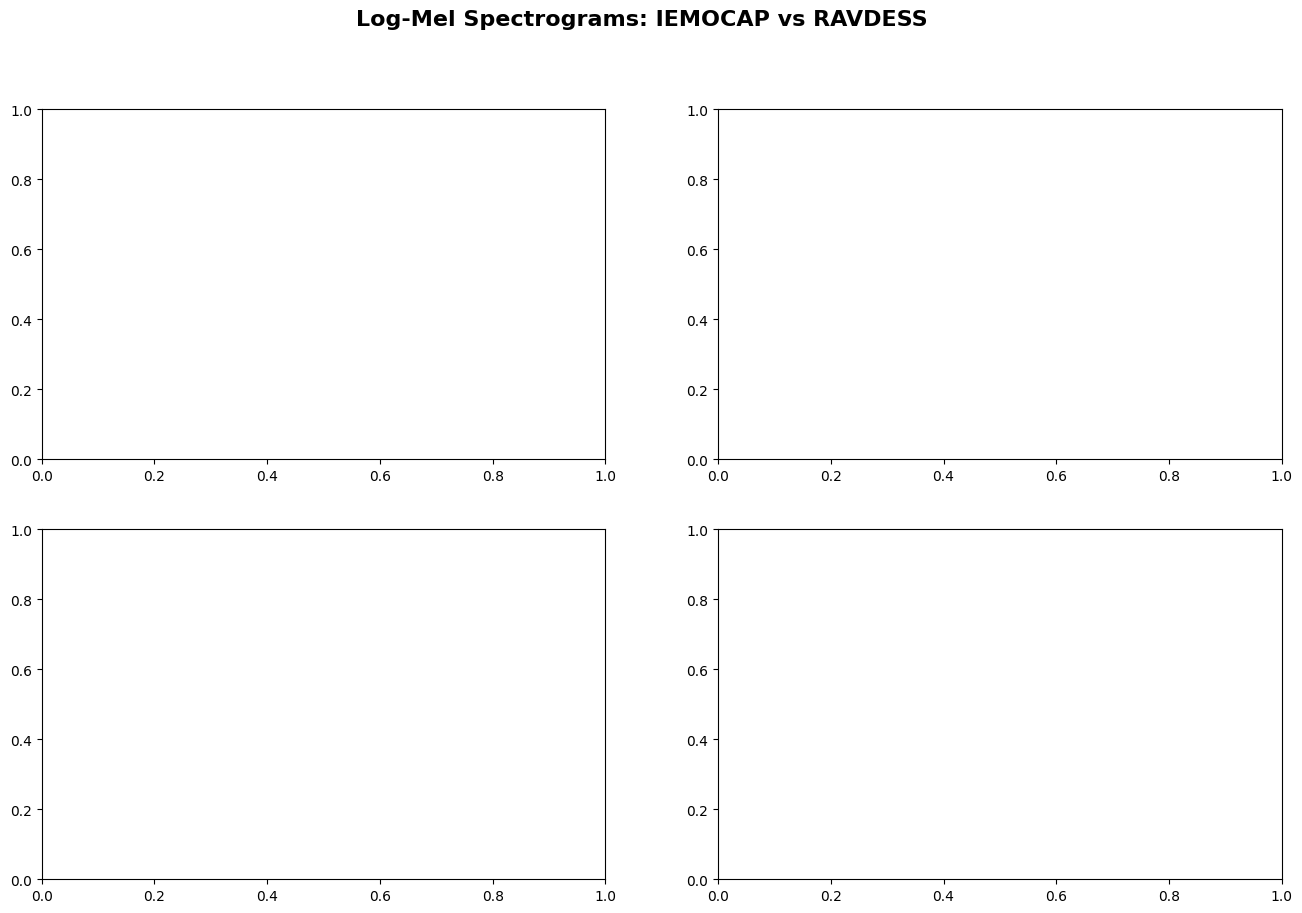

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Colori per le emozioni
emotion_colors = {
    'neutral': '#4285F4',  # Blu
    'happy': '#34A853',    # Verde
    'sad': '#EA4335',      # Rosso
    'angry': '#FBBC04'     # Giallo/Arancione
}

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Log-Mel Spectrograms: IEMOCAP vs RAVDESS', fontsize=16, fontweight='bold')

# ===== IEMOCAP =====
print("Loading IEMOCAP samples...")
iemocap_sample_1 = train_IEMOCAP_dataset[0]
iemocap_sample_2 = train_IEMOCAP_dataset[1]

# Plot IEMOCAP Sample 1
im1 = axes[0, 0].imshow(iemocap_sample_1['audio_features'].squeeze().numpy(), 
                        aspect='auto', origin='lower', cmap='viridis')
axes[0, 0].set_title(f"IEMOCAP Sample 1\nEmotion: {iemocap_sample_1['emotion']} | Actor: {iemocap_sample_1['actor_id']}", 
                     fontweight='bold')
axes[0, 0].set_ylabel('Mel Frequency Bins')
axes[0, 0].set_xlabel('Time Frames')
plt.colorbar(im1, ax=axes[0, 0], label='dB')

# Plot IEMOCAP Sample 2
im2 = axes[0, 1].imshow(iemocap_sample_2['audio_features'].squeeze().numpy(), 
                        aspect='auto', origin='lower', cmap='viridis')
axes[0, 1].set_title(f"IEMOCAP Sample 2\nEmotion: {iemocap_sample_2['emotion']} | Actor: {iemocap_sample_2['actor_id']}", 
                     fontweight='bold')
axes[0, 1].set_ylabel('Mel Frequency Bins')
axes[0, 1].set_xlabel('Time Frames')
plt.colorbar(im2, ax=axes[0, 1], label='dB')

# ===== RAVDESS =====
print("Loading RAVDESS samples...")
ravdess_sample_1 = train_RAVDESS_dataset[0]
ravdess_sample_2 = train_RAVDESS_dataset[1]

# Plot RAVDESS Sample 1
im3 = axes[1, 0].imshow(ravdess_sample_1['audio_features'].squeeze().numpy(), 
                        aspect='auto', origin='lower', cmap='viridis')
axes[1, 0].set_title(f"RAVDESS Sample 1\nEmotion: {ravdess_sample_1['emotion']} | Actor: {ravdess_sample_1['actor_id']}", 
                     fontweight='bold')
axes[1, 0].set_ylabel('Mel Frequency Bins')
axes[1, 0].set_xlabel('Time Frames')
plt.colorbar(im3, ax=axes[1, 0], label='dB')

# Plot RAVDESS Sample 2
im4 = axes[1, 1].imshow(ravdess_sample_2['audio_features'].squeeze().numpy(), 
                        aspect='auto', origin='lower', cmap='viridis')
axes[1, 1].set_title(f"RAVDESS Sample 2\nEmotion: {ravdess_sample_2['emotion']} | Actor: {ravdess_sample_2['actor_id']}", 
                     fontweight='bold')
axes[1, 1].set_ylabel('Mel Frequency Bins')
axes[1, 1].set_xlabel('Time Frames')
plt.colorbar(im4, ax=axes[1, 1], label='dB')

plt.tight_layout()
plt.show()

# ===== Stampa delle statistiche =====
print("\n" + "="*80)
print("SAMPLE DETAILS")
print("="*80)

print("\n📊 IEMOCAP Sample 1:")
print(f"   Emotion: {iemocap_sample_1['emotion']} (ID: {iemocap_sample_1['emotion_id']})")
print(f"   Actor: {iemocap_sample_1['actor_id']}")
print(f"   Spectrogram Shape: {iemocap_sample_1['audio_features'].shape} (channels, mel_bins, time_frames)")
print(f"   Min value: {iemocap_sample_1['audio_features'].min().item():.2f} dB")
print(f"   Max value: {iemocap_sample_1['audio_features'].max().item():.2f} dB")
print(f"   Mean value: {iemocap_sample_1['audio_features'].mean().item():.2f} dB")

print("\n📊 IEMOCAP Sample 2:")
print(f"   Emotion: {iemocap_sample_2['emotion']} (ID: {iemocap_sample_2['emotion_id']})")
print(f"   Actor: {iemocap_sample_2['actor_id']}")
print(f"   Spectrogram Shape: {iemocap_sample_2['audio_features'].shape}")
print(f"   Min value: {iemocap_sample_2['audio_features'].min().item():.2f} dB")
print(f"   Max value: {iemocap_sample_2['audio_features'].max().item():.2f} dB")
print(f"   Mean value: {iemocap_sample_2['audio_features'].mean().item():.2f} dB")

print("\n📊 RAVDESS Sample 1:")
print(f"   Emotion: {ravdess_sample_1['emotion']} (ID: {ravdess_sample_1['emotion_id']})")
print(f"   Actor: {ravdess_sample_1['actor_id']}")
print(f"   Spectrogram Shape: {ravdess_sample_1['audio_features'].shape}")
print(f"   Min value: {ravdess_sample_1['audio_features'].min().item():.2f} dB")
print(f"   Max value: {ravdess_sample_1['audio_features'].max().item():.2f} dB")
print(f"   Mean value: {ravdess_sample_1['audio_features'].mean().item():.2f} dB")

print("\n📊 RAVDESS Sample 2:")
print(f"   Emotion: {ravdess_sample_2['emotion']} (ID: {ravdess_sample_2['emotion_id']})")
print(f"   Actor: {ravdess_sample_2['actor_id']}")
print(f"   Spectrogram Shape: {ravdess_sample_2['audio_features'].shape}")
print(f"   Min value: {ravdess_sample_2['audio_features'].min().item():.2f} dB")
print(f"   Max value: {ravdess_sample_2['audio_features'].max().item():.2f} dB")
print(f"   Mean value: {ravdess_sample_2['audio_features'].mean().item():.2f} dB")

print("\n✅ Samples are ready for training!")


# Step 4: Train your model and visualize training

In [ ]:
#%env WANDB_API_KEY="7ade30086de7899bed412e3eb5c2da065c146f90"

In [ ]:
#!python train.py

# Step 5: Evaluate your model

1.   List item
2.   List item



In [ ]:
#!python eval.py